# fMRI data

* **Train/Test split**
* **Organize fMRI_id -> nsd_image_id mapping**
* **Retrieve info about the memory**

In [1]:
import os
import sys
import numpy as np
import h5py
import scipy.io as spio
import nibabel as nib

import pandas as pd
import copy

import pickle 

def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
    
def save_pickle(data, path):
    with open(path, 'wb') as file:
        pickle.dump(data, file)
    
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [2]:
SUBJECT = 7 # 1, 2, 5, 7
SUBJECT_IDX = SUBJECT - 1 # for indexing

stim_order_f = '/SSD/slava/brain_decoding/nsd/data/nsddata/experiments/nsd/nsd_expdesign.mat'
stim_order = loadmat(stim_order_f)

nsd_stim_info = pd.read_pickle('/SSD/slava/brain_decoding/nsd/data/nsddata/experiments/nsd/nsd_stim_info_merged.pkl')


/tmp/ipykernel_15410/429114225.py:35: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):


In [3]:
print(stim_order['subjectim'][0].shape, stim_order['masterordering'][0])

print(nsd_stim_info.shape)

(10000,) 626
(73000, 40)


In [4]:
fmri_train_sequence = {} # fMRI_id -> nsd_image_id
sig_train = {} # nsd_image_id -> list of fMRI_ids 

fmri_test_sequence = {}
sig_test = {}

num_trials = 37*750 # completed all trials 

for idx in range(num_trials):
    ''' nsdId as in design csv files'''
    nsdId = stim_order['subjectim'][SUBJECT-1, stim_order['masterordering'][idx] - 1] - 1
    if stim_order['masterordering'][idx]>1000:
        fmri_train_sequence[idx] = nsdId
        if nsdId not in sig_train:
            sig_train[nsdId] = []
        sig_train[nsdId].append(idx)
    else:
        fmri_test_sequence[idx] = nsdId
        
        if nsdId not in sig_test:
            sig_test[nsdId] = []
        sig_test[nsdId].append(idx)
    

print("Train: ", len(fmri_train_sequence), len(set(fmri_train_sequence.values())))
print("Test: ", len(fmri_test_sequence), len(set(fmri_test_sequence.values())))

Train:  24980 8859
Test:  2770 982


In [5]:
stimpattern = stim_order['stimpattern']
stimpattern = stimpattern.astype(np.int32)

stimpattern[stimpattern == 0] = -1
stimpattern[stimpattern == 1] = range(30000) # fmri orderings

memory_size = 20

fmri_sequence = {} # fMRI_id -> {"past": [previous scans fMRI_ids], "future": [future scans fMRI_ids]}

for session_id in range(37):
    
    for run_id in range(12):
        sp = copy.deepcopy(stimpattern[session_id, run_id])  # 0-based, [75]
        # pad left with -1, size is memory_size + size
        sp = np.pad(sp, (memory_size, memory_size), mode="constant", constant_values=-1)
            
        for idx, trial_id in enumerate(sp):
            if trial_id==-1:
                continue
            else:
                
                fmri_sequence[trial_id] = {}
                fmri_sequence[trial_id]['past'] = sp[idx-memory_size:idx][::-1]
                fmri_sequence[trial_id]['future'] = sp[idx+1:idx+memory_size]
                


In [6]:
idx = 2
print(fmri_sequence[idx], fmri_train_sequence[idx], sig_train[fmri_train_sequence[idx]])

{'past': array([ 1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1], dtype=int32), 'future': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, -1, 12, 13, 14, 15, 16, 17, 18,
       19, 20], dtype=int32)} 9386 [2, 10933, 11357]


In [7]:
# save all files

save_pickle(fmri_train_sequence,
           f'/SSD/slava/THESIS/NSD_processed/subj{SUBJECT}_train_mri_to_nsd-img.pkl')

save_pickle(sig_train,
           f'/SSD/slava/THESIS/NSD_processed/subj{SUBJECT}_train_nsd-img_to_fmri.pkl')

save_pickle(fmri_test_sequence,
           f'/SSD/slava/THESIS/NSD_processed/subj{SUBJECT}_test_mri_to_nsd-img.pkl')

save_pickle(sig_test,
           f'/SSD/slava/THESIS/NSD_processed/subj{SUBJECT}_test_nsd-img_to_fmri.pkl')

save_pickle(fmri_sequence,
           f'/SSD/slava/THESIS/NSD_processed/subj{SUBJECT}_fmri_sequence_memory.pkl')

# COCO dataset

In [1]:
import json

import requests
from io import BytesIO
from PIL import Image

from collections import defaultdict
import pandas as pd

from tqdm import tqdm

def load_image(image_file):
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    return image

def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

train_captions = load_json('/SSD/slava/THESIS/coco_annotations/captions_train2017.json')

In [2]:
print(f'Anno len: {len(train_captions["annotations"])},Img len: {len(train_captions["images"])}')
print(f'Anno/Img ratio: {len(train_captions["annotations"])/len(train_captions["images"]) :.3f}')

Anno len: 591753,Img len: 118287
Anno/Img ratio: 5.003


Caption:  This picture shows a very colorful area with many suitcases piled up with other interesting things around them.  


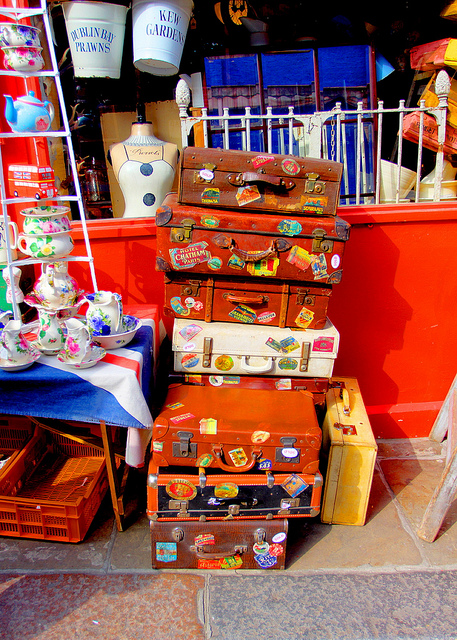

In [3]:
iD = 100

caps = [ item  for item in train_captions['annotations'] if item['id'] == iD][0]
imgs = [ item  for item in train_captions['images'] if item['id'] == caps['image_id']][0]

loaded_img = load_image(imgs['coco_url'])
print('Caption: ', caps['caption'])
loaded_img

In [4]:
print("Caption: ", caps)
print("Image: ", imgs)

Caption:  {'image_id': 452441, 'id': 100, 'caption': 'This picture shows a very colorful area with many suitcases piled up with other interesting things around them.  '}
Image:  {'license': 3, 'file_name': '000000452441.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000452441.jpg', 'height': 640, 'width': 457, 'date_captured': '2013-11-18 08:16:24', 'flickr_url': 'http://farm6.staticflickr.com/5101/5629832127_fd30178f6e_z.jpg', 'id': 452441}


## Organize data into csv format

`columns:` **image_id: `str`**, **captions: `List[str]`**, *other Image variables*

In [5]:
def parse_coco_to_csv(imgs, caps):
    
    captions = defaultdict(list)
    
    for cap in caps: 
        captions[cap['image_id']].append(cap['caption'])
    
    data = []
    for idx, item in tqdm(enumerate(imgs), total=len(imgs)):
               
        item['captions'] = captions[item['id']]
        data.append(item)
    
    return pd.DataFrame(data)

train_df = parse_coco_to_csv(train_captions['images'], train_captions['annotations'])


100%|█████████████████████████████████████████████████████████████████████████████████████| 118287/118287 [00:00<00:00, 878706.30it/s]


In [6]:
print(train_df.shape)
train_df.head()

(118287, 9)


,license,file_name,coco_url,height,width,date_captured,flickr_url,id,captions
0,3,000000391895.jpg,http://images.cocodataset.org/train2017/000000...,360,640,2013-11-14 11:18:45,http://farm9.staticflickr.com/8186/8119368305_...,391895,[A man with a red helmet on a small moped on a...
1,4,000000522418.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-14 11:38:44,http://farm1.staticflickr.com/1/127244861_ab0c...,522418,[A woman wearing a net on her head cutting a c...
2,3,000000184613.jpg,http://images.cocodataset.org/train2017/000000...,336,500,2013-11-14 12:36:29,http://farm3.staticflickr.com/2169/2118578392_...,184613,[A child holding a flowered umbrella and petti...
3,3,000000318219.jpg,http://images.cocodataset.org/train2017/000000...,640,556,2013-11-14 13:02:53,http://farm5.staticflickr.com/4125/5094763076_...,318219,[A young boy standing in front of a computer k...
4,3,000000554625.jpg,http://images.cocodataset.org/train2017/000000...,640,426,2013-11-14 16:03:19,http://farm5.staticflickr.com/4086/5094162993_...,554625,[a boy wearing headphones using one computer i...


In [7]:
test_captions = load_json('/SSD/slava/THESIS/coco_annotations/captions_val2017.json')

test_df = parse_coco_to_csv(test_captions['images'], test_captions['annotations'])

100%|████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1122732.48it/s]


In [8]:
print(test_df.shape)
test_df.head()

(5000, 9)


,license,file_name,coco_url,height,width,date_captured,flickr_url,id,captions
0,4,000000397133.jpg,http://images.cocodataset.org/val2017/00000039...,427,640,2013-11-14 17:02:52,http://farm7.staticflickr.com/6116/6255196340_...,397133,"[A man is in a kitchen making pizzas., Man in ..."
1,1,000000037777.jpg,http://images.cocodataset.org/val2017/00000003...,230,352,2013-11-14 20:55:31,http://farm9.staticflickr.com/8429/7839199426_...,37777,[The dining table near the kitchen has a bowl ...
2,4,000000252219.jpg,http://images.cocodataset.org/val2017/00000025...,428,640,2013-11-14 22:32:02,http://farm4.staticflickr.com/3446/3232237447_...,252219,[a person with a shopping cart on a city stree...
3,1,000000087038.jpg,http://images.cocodataset.org/val2017/00000008...,480,640,2013-11-14 23:11:37,http://farm8.staticflickr.com/7355/8825114508_...,87038,[A person on a skateboard and bike at a skate ...
4,6,000000174482.jpg,http://images.cocodataset.org/val2017/00000017...,388,640,2013-11-14 23:16:55,http://farm8.staticflickr.com/7020/6478877255_...,174482,"[a blue bike parked on a side walk , A bicycle..."


In [9]:
train_df['source'] = 'train2017'
test_df['source'] = 'val2017'

total_coco = pd.concat([train_df, test_df])
print(total_coco.shape)

total_coco.to_csv('/SSD/slava/THESIS/total_coco.csv', index=False)

(123287, 10)


# fMRI COCO relationship

In [8]:
import h5py
import pandas as pd

import matplotlib.pyplot as plt


In [2]:
f_stim = h5py.File('/SSD/slava/brain_decoding/nsd/data/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5', 'r')
stim = f_stim['imgBrick'][:]

print("Stimuli are loaded. Images: ", stim.shape)

Stimuli are loaded. Images:  (73000, 425, 425, 3)


In [6]:
nsd_stim_info = pd.read_pickle('/SSD/slava/brain_decoding/nsd/data/nsddata/experiments/nsd/nsd_stim_info_merged.pkl')
print("Stimuli info: ", nsd_stim_info.shape)
nsd_stim_info.head()

Stimuli info:  (73000, 40)


,cocoId,cocoSplit,cropBox,loss,nsdId,flagged,BOLD5000,shared1000,subject1,subject2,...,subject5_rep2,subject6_rep0,subject6_rep1,subject6_rep2,subject7_rep0,subject7_rep1,subject7_rep2,subject8_rep0,subject8_rep1,subject8_rep2
0,532481,val2017,"(0, 0, 0.1671875, 0.1671875)",0.100000,0,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
1,245764,val2017,"(0, 0, 0.125, 0.125)",0.000000,1,False,False,False,0,0,...,0,0,0,0,13985,14176,28603,0,0,0
2,385029,val2017,"(0, 0, 0.125, 0.125)",0.000000,2,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
3,311303,val2017,"(0, 0, 0.16640625, 0.16640625)",0.125000,3,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
4,393226,val2017,"(0, 0, 0.125, 0.125)",0.133333,4,False,False,False,0,0,...,0,13720,22861,23023,0,0,0,0,0,0


In [7]:
coco_total_df = pd.read_csv('/SSD/slava/THESIS/total_coco.csv')

print(coco_total_df.shape)

(123287, 10)


Captions:  ['A group of stuffed bears that are sitting on fake grass.', 'A nice setup of stuffed bears having a picnic. ', 'A group of stuffed bears are arranged in a display.', 'A group of elephants on a grass surface.', 'some teddy bears dressed and posed for a picnic ']


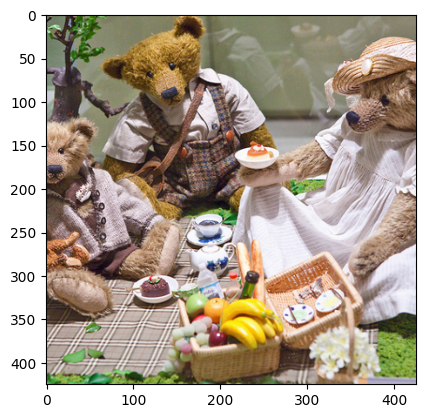

In [15]:
nsd_img_id = 500
coco_id = nsd_stim_info.iloc[nsd_img_id]['cocoId']
captions = coco_total_df[coco_total_df['id']==coco_id]

assert len(captions) == 1

captions = captions.iloc[0]['captions']

print("Captions: ", captions)

plt.imshow(stim[nsd_img_id])
plt.show()

# Conclusion

As the notebook ends here, let's discuss what we did here. 

First, we divided NSD data for a particular subject *(1,2,5,7 because these four subjects completed all sessions)* into train/test set. 

Then, we extracted 3 dictionaries for each split.
1. fMRI_id -> nsd_img_id
2. nsd_img_id -> list of fMRI_ids because one image was shown couple of times 
3. memory dictionary. Given a fMRI_id, we can retrieve the ids of past or future scans 

After that, we organized COCO dataset.

- `total_coco.csv`: coco_id -> coco_captions 
